# Ανάλυση Προτύπων 

## Εργαστήριο 2

In [1]:
%matplotlib inline

from tabulate import tabulate
import matplotlib
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import librosa
import numpy as np
from scipy.fftpack import dct, idct

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from pomegranate import GeneralMixtureModel, HiddenMarkovModel, MultivariateGaussianDistribution

import parser
import lib
import lstm

import importlib
import joblib
import os.path

In [2]:
importlib.reload(lib)
importlib.reload(parser)

<module 'parser' from '/root/jason/PatRec/Lab2/parser.py'>

## Προπαρασκευή

### Βήμα 2

In [3]:
fs = 16000 # sampling rate 

In [4]:
wavs, speakers, digits = lib.data_parser("digits/")

### Βήμα 3

In [5]:
hop_time = 0.010 # 10ms
window_time = 0.025 # 25ms

hop_samples = int(hop_time * fs)
window_samples = int(window_time * fs)

In [6]:
mfcc_list = []
for wav in wavs:
    mfcc_list.append(lib.calc_mfcc(wav, hop_samples, window_samples))

In [7]:
# Default axis = -1 chooses columns

deltas = [librosa.feature.delta(mfcc) for mfcc in mfcc_list]
delta_deltas = [librosa.feature.delta(mfcc, order=2) for mfcc in mfcc_list]

### Βήμα 4

In [8]:
n1 = 'six' # 03117169
n2 = 'nine' # 03117089

In [9]:
n1_mfcc_list = [mfcc for mfcc, digit in zip(mfcc_list, digits) if digit == n1]
n2_mfcc_list = [mfcc for mfcc, digit in zip(mfcc_list, digits) if digit == n2]

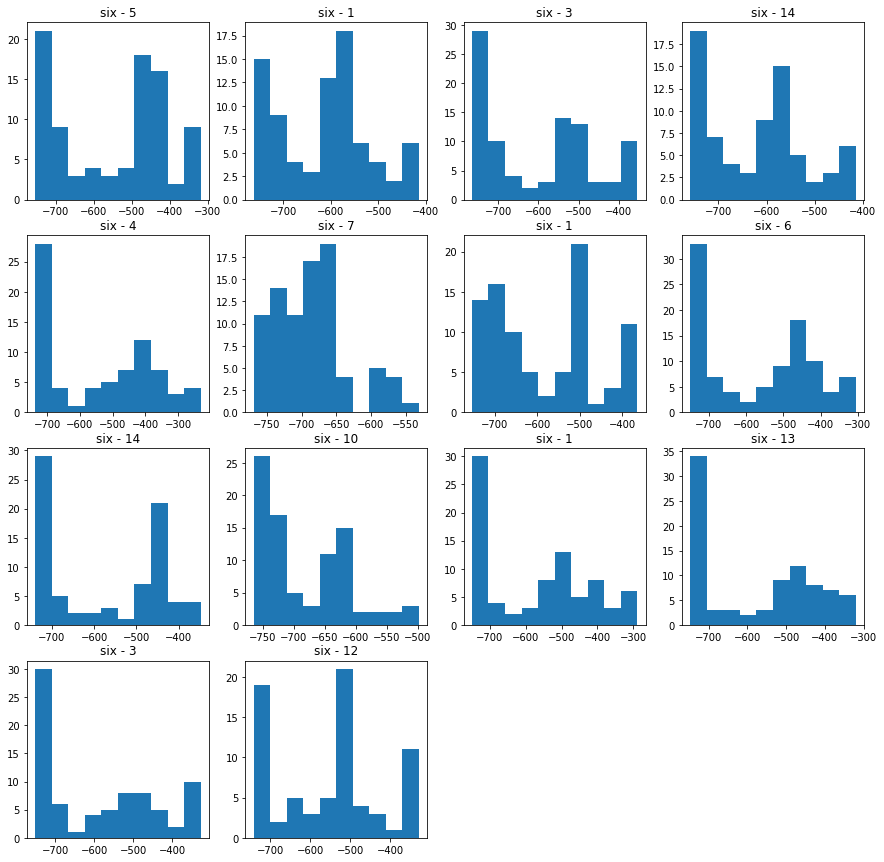

In [10]:
n1_first_feature = [mfcc[0] for mfcc in n1_mfcc_list]

n1_size = len(n1_mfcc_list)
rows = 4
cols = int(n1_size / rows) + 1

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
axs = axs.flatten()

for ax in axs:
    ax.set_axis_off()

for x, speaker, ax in zip(n1_first_feature, speakers, axs):
    ax.hist(x)
    ax.set_axis_on()
    ax.set_title(f"{n1} - {speaker}")

plt.show()

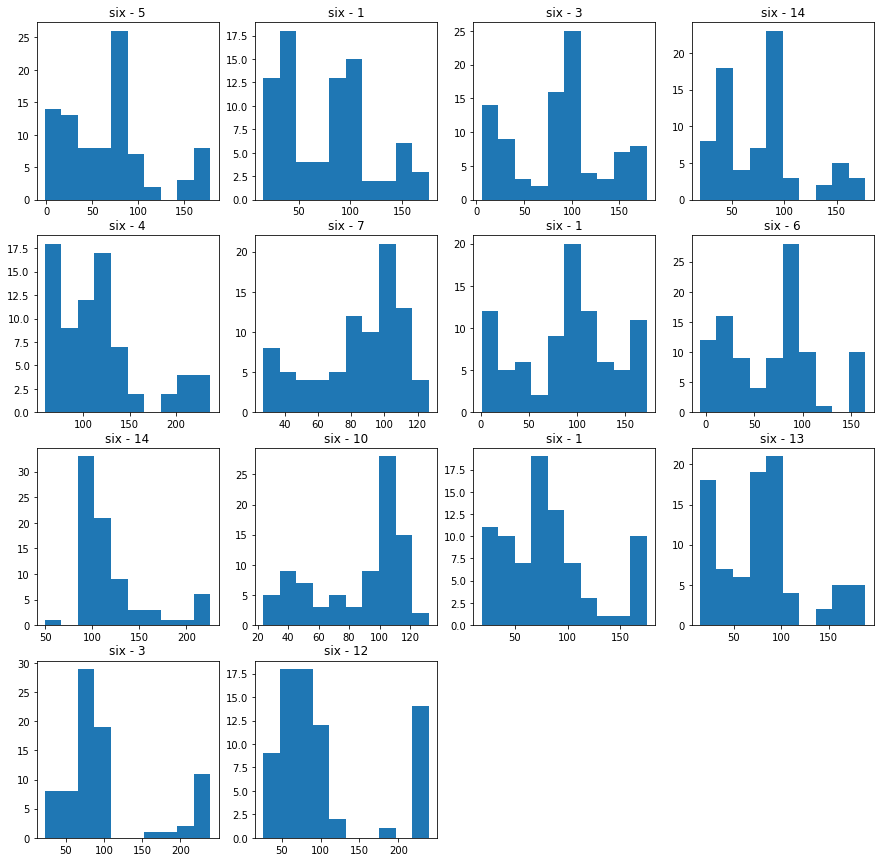

In [11]:
n1_second_feature = [mfcc[1] for mfcc in n1_mfcc_list]

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
axs = axs.flatten()

for ax in axs:
    ax.set_axis_off()

for x, speaker, ax in zip(n1_second_feature, speakers, axs):
    ax.hist(x)
    ax.set_axis_on()
    ax.set_title(f"{n1} - {speaker}")

plt.show()

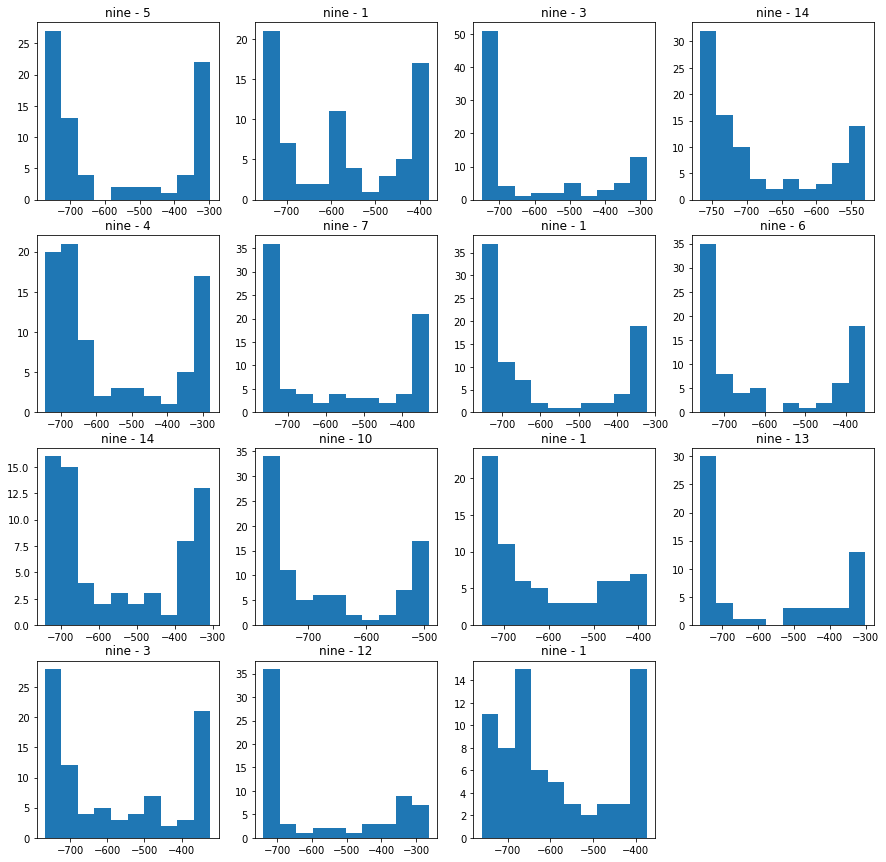

In [12]:
n2_first_feature = [mfcc[0] for mfcc in n2_mfcc_list]

n2_size = len(n2_mfcc_list)
rows = 4
cols = int(n2_size / rows) + 1

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
axs = axs.flatten()

for ax in axs:
    ax.set_axis_off()

for x, speaker, ax in zip(n2_first_feature, speakers, axs):
    ax.hist(x)
    ax.set_axis_on()
    ax.set_title(f"{n2} - {speaker}")

plt.show()

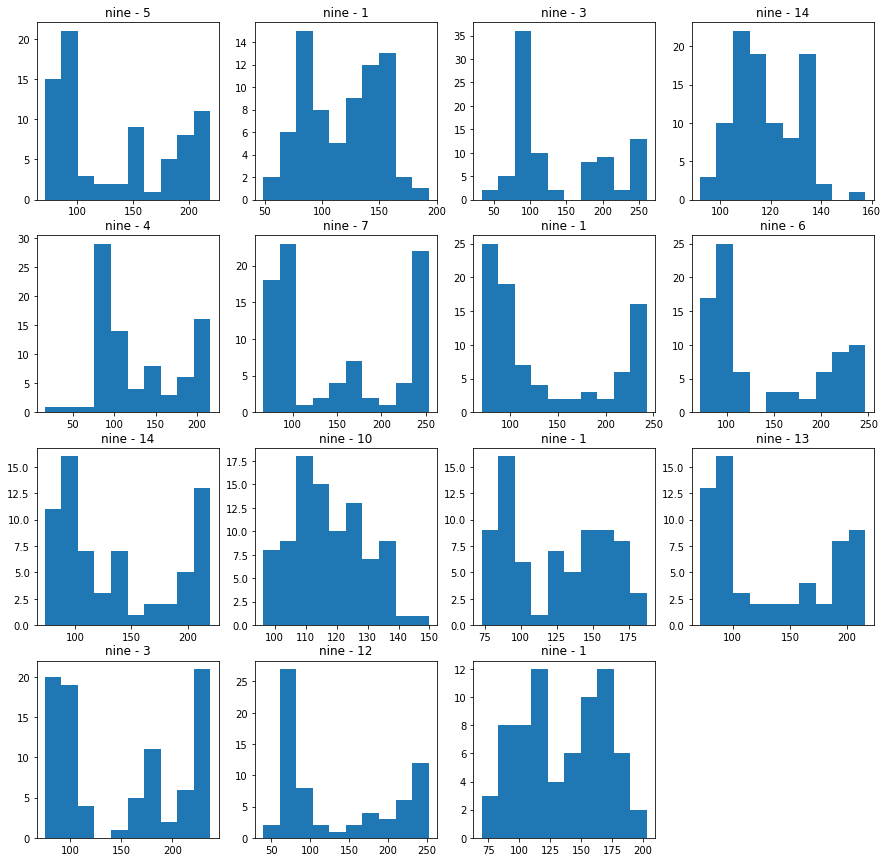

In [13]:
n2_second_feature = [mfcc[1] for mfcc in n2_mfcc_list]

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
axs = axs.flatten()

for ax in axs:
    ax.set_axis_off()

for x, speaker, ax in zip(n2_second_feature, speakers, axs):
    ax.hist(x)
    ax.set_axis_on()
    ax.set_title(f"{n2} - {speaker}")

plt.show()

In [15]:
# Find six1, six2, nine1, nine2
n1_indices = [lib.choose_index(n1, '1', digits, speakers), lib.choose_index(n1, '2', digits, speakers)]
n2_indices = [lib.choose_index(n2, '1', digits, speakers), lib.choose_index(n2, '2', digits, speakers)]

n1_mfscs = []
n1_mfccs = []
for i in n1_indices:
    mfcc = lib.calc_mfcc(wavs[i], hop_samples, window_samples)
    n1_mfscs.append(idct(mfcc))
    n1_mfccs.append(mfcc)
n1_xarr_mfsc = [np.corrcoef(mfsc) for mfsc in n1_mfscs]
n1_xarr_mfcc = [np.corrcoef(mfcc) for mfcc in n1_mfccs]

n2_mfscs = []
n2_mfccs = []
for i in n2_indices:
    mfcc = lib.calc_mfcc(wavs[i], hop_samples, window_samples)
    n2_mfccs.append(mfcc)
    n2_mfscs.append(idct(mfcc)) 
n2_xarr_mfsc = [np.corrcoef(mfsc) for mfsc in n2_mfscs]
n2_xarr_mfcc = [np.corrcoef(mfcc) for mfcc in n2_mfccs]

MFSCs


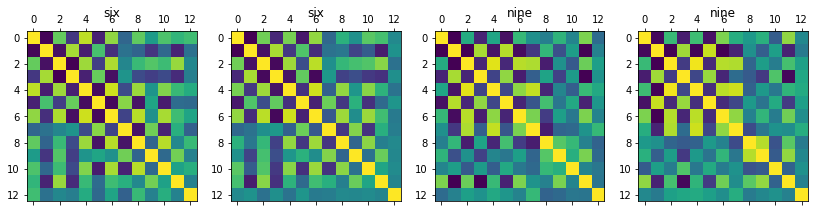

In [28]:
print("MFSCs")
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(14, 14))
for ax, xarr in zip(axs, np.concatenate((n1_xarr_mfsc, n2_xarr_mfsc), axis=0)):
    ax.matshow(xarr)

axs[0].set_title(f"{n1}")
axs[1].set_title(f"{n1}")
axs[2].set_title(f"{n2}")
axs[3].set_title(f"{n2}")

plt.show()

MFCCs


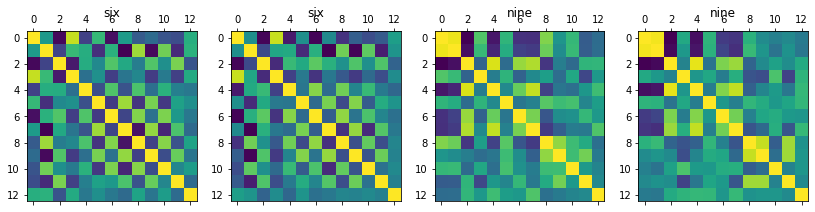

In [31]:
print("MFCCs")
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(14, 14))
for ax, xarr in zip(axs, np.concatenate((n1_xarr_mfcc, n2_xarr_mfcc), axis=0)):
    ax.matshow(xarr)

axs[0].set_title(f"{n1}")
axs[1].set_title(f"{n1}")
axs[2].set_title(f"{n2}")
axs[3].set_title(f"{n2}")

plt.show()

### Βήμα 5

In [20]:
# Transform digits to list of integers
digits_dict = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}
digits_int = [digits_dict[digit] for digit in digits]

# Transform speakers to list of integers from 1 to 15
speakers_dict = {'1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10, '11':11, '12':12, '13':13, '14':14, '15':15}
speakers_int = [speakers_dict[speaker] for speaker in speakers]

In [21]:
data_mean = [np.array([mfcc.mean(axis=1), delta.mean(axis=1), delta2.mean(axis=1)]).ravel() for mfcc, delta, delta2 in zip(mfcc_list, deltas, delta_deltas)]
data_mean = np.array(data_mean)
print(data_mean.shape)

data_std = [np.array([mfcc.std(axis=1), delta.std(axis=1), delta2.std(axis=1)]).ravel() for mfcc, delta, delta2 in zip(mfcc_list, deltas, delta_deltas)]
data_std = np.array(data_std)
print(data_std.shape)

(133, 39)
(133, 39)


In [22]:
# Assign a color to numbers from 1 to 9
color_dict = {1: 'red', 2: 'green', 3: 'blue', 4: 'yellow', 5: 'orange', 6: 'purple', 7: 'black', 8: 'cyan', 9: 'magenta'}

# Assign a marker to numbers from 1 to 15
marker_dict = {1: 'o', 2: '^', 3: 's', 4: '*', 5: '+', 6: 'x', 7: 'D', 8: 'd', 9: 'h', 10: 'p', 11: 'v', 12: '<', 13: '>', 14: '8', 15: '1'}

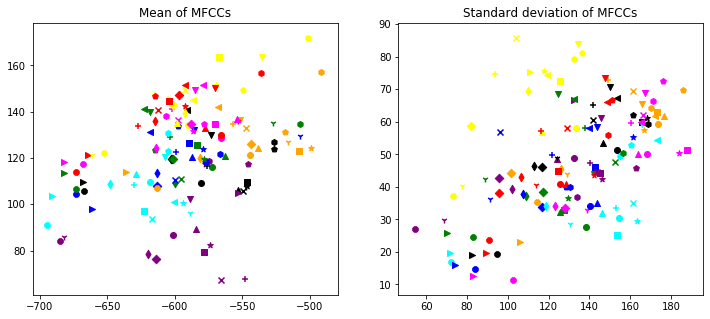

In [23]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for d, s, mean, std in zip(digits_int, speakers_int, data_mean, data_std):
    ax0.scatter([mean[0]], [mean[1]], c=color_dict[d], marker=marker_dict[s])
    ax0.set_title(f"Mean of MFCCs")

    ax1.scatter([std[0]], [std[1]], c=color_dict[d], marker=marker_dict[s])
    ax1.set_title(f"Standard deviation of MFCCs")

plt.show()

### Βήμα 6

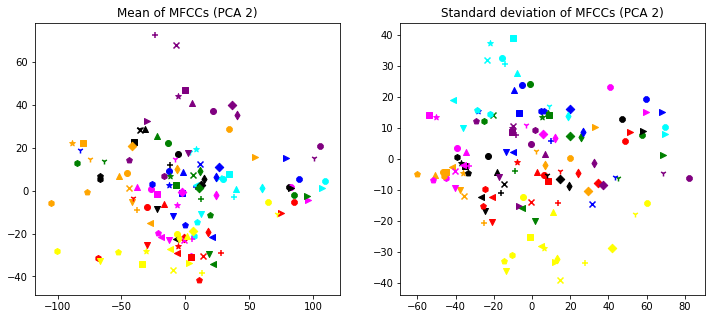

In [24]:
# Apply PCA to the data
pca_2 = PCA(n_components=2)
data_mean_pca_2 = pca_2.fit_transform(data_mean)
data_std_pca_2 = pca_2.fit_transform(data_std)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for d, s, mean, std in zip(digits_int, speakers_int, data_mean_pca_2, data_std_pca_2):
    ax0.scatter([mean[0]], [mean[1]], c=color_dict[d], marker=marker_dict[s])
    ax0.set_title(f"Mean of MFCCs (PCA 2)")

    ax1.scatter([std[0]], [std[1]], c=color_dict[d], marker=marker_dict[s])
    ax1.set_title(f"Standard deviation of MFCCs (PCA 2)")

plt.show()

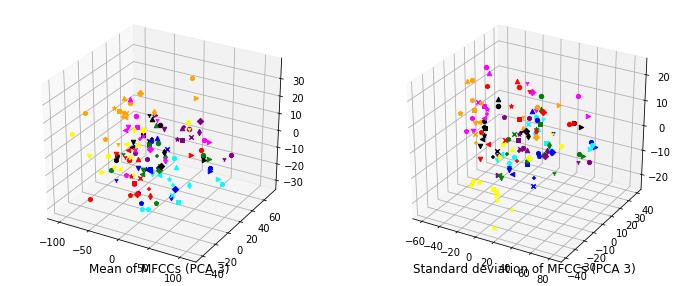

In [27]:
# Apply PCA to the data
pca_3 = PCA(n_components=3)
data_mean_pca_3 = pca_3.fit_transform(data_mean)
data_std_pca_3 = pca_3.fit_transform(data_std)

fig = plt.figure(figsize=(12, 5))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')

for d, s, mean, std in zip(digits_int, speakers_int, data_mean_pca_3, data_std_pca_3):
    ax0.scatter([mean[0]], [mean[1]], [mean[2]], c=color_dict[d], marker=marker_dict[s])
    ax0.set_title(f"Mean of MFCCs (PCA 3)")

    ax1.scatter([std[0]], [std[1]], [std[2]], c=color_dict[d], marker=marker_dict[s])
    ax1.set_title(f"Standard deviation of MFCCs (PCA 3)")

plt.show()

In [28]:
print(f"The remaining variance of 2 PCA components is {sum(pca_2.explained_variance_ratio_) * 100:.4f}%")
print(f"The remaining variance of 3 PCA components is {sum(pca_3.explained_variance_ratio_) * 100:.4f}%")

The remaining variance of 2 PCA components is 83.9019%
The remaining variance of 3 PCA components is 90.7052%


### Βήμα 7

In [29]:
# Every sample has both them means and the std of the MFCCs
data = np.concatenate((data_mean, data_std),axis=1)

# Split into train test 70 - 30
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data, digits_int, test_size=0.3, random_state=42)

In [30]:
NaiveBayes = GaussianNB()
svc = SVC(kernel='linear')
KNNeighbors = KNeighborsClassifier(n_neighbors=1)
RandomForest = RandomForestClassifier()

classifiers = [NaiveBayes, svc, KNNeighbors, RandomForest]
preprocessor = sk.preprocessing.StandardScaler()

for clf in classifiers:
    pipeline = make_pipeline(preprocessor, clf)
    pipeline.fit(X_train, y_train)
    accuracy = sk.metrics.accuracy_score(y_test, pipeline.predict(X_test))
    print(f"Classifier {clf.__class__.__name__} has accuracy {accuracy * 100:.3f}%")
    #print(sk.metrics.classification_report(y_test, pipeline.predict(X_test), zero_division=0))

Classifier GaussianNB has accuracy 60.000%
Classifier SVC has accuracy 67.500%
Classifier KNeighborsClassifier has accuracy 57.500%
Classifier RandomForestClassifier has accuracy 55.000%


/root/anaconda3/envs/lab2/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Βήμα 8

In [2]:
n_samples = 1000 # Number of sequences to generate
n_steps = 10 # Length of each sequence

f = 40
T = 1 / f
omega = 2 * np.pi * f

# Generate n_samples random sine/cosine sequences
X = np.zeros((n_samples, n_steps))
Y = np.zeros((n_samples, n_steps))
window = T/2
for i in range(n_samples):
    # Random amplitude
    ampl = np.random.uniform(0, 5)

    # Random start
    start = np.random.uniform(0, 1)
    x = np.linspace(start, start + window, n_steps)
    
    # Add sequences
    X[i] = ampl * np.sin(omega * x)
    Y[i] = ampl * np.cos(omega * x)

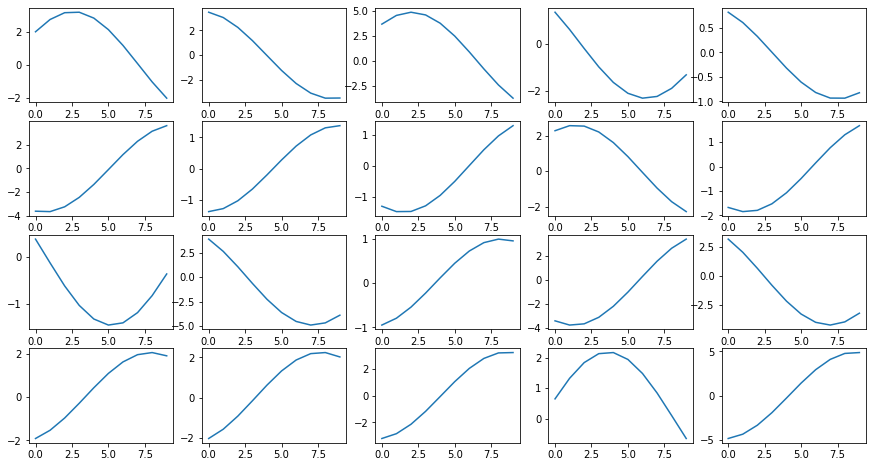

In [43]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 8))
for ax, y in zip(axs.flatten(), Y[:20]):
    ax.plot(np.arange(10), y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [4]:
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTMCell(1, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs



In [5]:
model = LSTMNet().double()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
train_losses = []
test_losses = []

table = []
epochs = 1500
for i in range(epochs):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    train_loss = loss.item()

    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        pred = model(X_test)
        loss = criterion(pred, y_test)
        test_loss = loss.item()
        test_losses.append(loss.item())
    
    if i % 100 == 0: 
        table.append((i, train_loss, test_loss))

print(tabulate(table, headers=['Epoch', 'Train loss', 'Test loss']))

  Epoch    Train loss    Test loss
-------  ------------  -----------
      0      4.25266      4.05349
    100      1.47967      1.41883
    200      1.01004      0.96206
    300      0.677467     0.651053
    400      0.554009     0.533944
    500      0.479394     0.467011
    600      0.441442     0.433598
    700      0.429507     0.424874
    800      0.426225     0.423182
    900      0.424769     0.422564
   1000      0.423839     0.422199
   1100      0.423231     0.42202
   1200      0.422802     0.42192
   1300      0.422496     0.421874
   1400      0.422448     0.422035


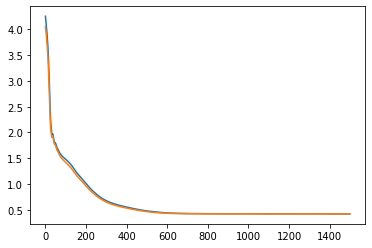

In [7]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(test_losses)), test_losses)

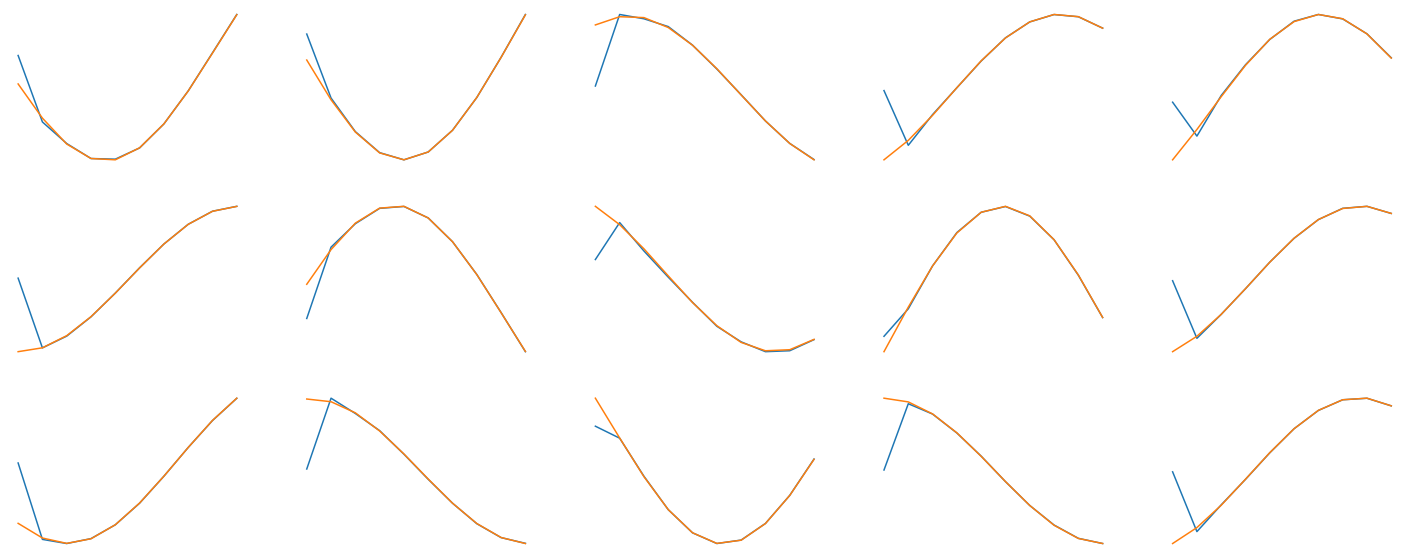

In [8]:
fig = plt.figure(figsize=(25,10))
columns = 5
rows = 3

samples = np.random.randint(0, 200, 15)

for i in range(15):
    # Display the randomly selected image in a subplot
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    with torch.no_grad():
        pred = model(X_test[samples[i]].view(1,-1))
    plt.plot(np.arange(10), pred[0])
    plt.plot(np.arange(10), y_test[samples[i]])

## Εργαστηριακό μέρος

### Βήμα 9

In [8]:
# Only run once to generate the data
if not os.path.isfile('data_dict.pkl'):
    X_train, X_test, y_train, y_test, spk_train, spk_test = parser.parser('recordings/')
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
    print("If using all data to calculate normalization statistics")
    scale_fn = parser.make_scale_fn(X_train + X_dev + X_test)
    print("If using X_train + X_dev to calculate normalization statistics")
    scale_fn = parser.make_scale_fn(X_train + X_dev)
    print("If using X_train to calculate normalization statistics")
    scale_fn = parser.make_scale_fn(X_train)
    #X_train = scale_fn(X_train)
    #X_dev = scale_fn(X_dev)
    #X_test = scale_fn(X_test)
    
    # Make dictionary with previous variables
    data_dict = {'X_train': X_train, 'X_dev': X_dev, 'X_test': X_test, 'y_train': y_train, 'y_dev': y_dev, 'y_test': y_test, 'spk_train': spk_train, 'spk_test': spk_test}

    # Save downloaded data to file
    joblib.dump(data_dict, 'data_dict.pkl')
else:
    data_dict = joblib.load('data_dict.pkl')

# Pass contents to variables
X_train = data_dict['X_train']
X_dev = data_dict['X_dev']
X_test = data_dict['X_test']
y_train = data_dict['y_train']
y_dev = data_dict['y_dev']
y_test = data_dict['y_test']
spk_train = data_dict['spk_train']
spk_test = data_dict['spk_test']

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_dev)}")
print(f"Test set size: {len(X_test)}")

Train set size: 2160
Validation set size: 540
Test set size: 300


### Βήμα 10

In [9]:
def create_hmm_model(X, n_states, n_mixtures, gmm=True):
    dists = []
    X_stacked = np.vstack(X)
    for i in range(n_states):
        #X_ = np.array(X.copy()).reshape(-1, 1)
        if gmm and n_mixtures > 1:
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, np.float_(X_stacked))
        else:
            a = MultivariateGaussianDistribution.from_samples(np.float_(X_stacked))
        dists.append(a)

    trans_mat = np.zeros((n_states, n_states)) # transition matrix
    for i in range(n_states):
        for j in range(n_states):
            if i == j or j == i+1:
                trans_mat[i, j] = 0.5 

    starts = np.zeros(n_states) # ending probability matrix
    starts[0] = 1 
    ends = np.zeros(n_states) # ending probability matrix
    ends[-1] = 1 
    
    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])
    model.fit(X, max_iterations=5)
    return model

### Βήμα 11

In [10]:
X_train_per_digit = []
for digit in range(10):
    X_tr_i = np.take(X_train, [i for i in range(len(X_train)) if y_train[i] == digit], axis=0)
    X_train_per_digit.append(X_tr_i)


def train_models(X, n_states, n_mixtures, gmm=True):
    digit_models = []
    for samples_of_digit in X:
        digit_models.append(create_hmm_model(samples_of_digit, n_states, n_mixtures, gmm))
    return digit_models

/root/anaconda3/envs/lab2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
#digit_train_samples = np.array([np.array([x for x, y in zip(X_train, y_train) if y == i]) for i in range(10)])
#digit_dev_samples = [[x for x, y in zip(X_dev, y_dev) if y == i] for i in range(10)]
#digit_test_samples = [[x for x, y in zip(X_test, y_test) if y == i] for i in range(10)]

### Βήμα 12

In [12]:
def eval_models(models, X_val, y_val, n):
    cm = np.zeros((10, 10)) # confusion matrix
    y_preds = np.zeros(n, dtype='int') # predictions
    for i in range(n):
        logs = np.zeros(10)
        # Evaluate the sample in each model and decode it to the digit with the highest log-likelihood.
        for j in range(10):
            logp, _ = models[j].viterbi(X_val[i]) # Run viterbi algorithm and return log-probability
            logs[j] = logp
        y_preds[i] = np.argmax(logs)
        cm[y_val[i], y_preds[i]] += 1
    acc = sum(y_preds == y_val) / n
    
    return acc, cm

In [13]:
n_states_ = [1, 2, 3, 4]
n_mixtures_ = [1, 2, 3, 4, 5]

accs = []
# Only train/evaluate if it is the first time
if not os.path.isfile('accs.pkl'):
    for n_states in n_states_:
        for n_mixtures in n_mixtures_:
            #print(n_states, n_mixtures)
            models = train_models(X_train_per_digit, n_states, n_mixtures, True)
            acc, _ = eval_models(models, X_dev, y_dev, len(X_dev))
            accs.append(acc)
    joblib.dump(accs, 'accs.pkl')
else:
    accs = joblib.load('accs.pkl')

In [14]:
models_table = []
for i, n_states in enumerate(n_states_):
    for j, n_mixtures in enumerate(n_mixtures_):
        models_table.append((n_states, n_mixtures, accs[i+j]))

print(tabulate(models_table, headers=['n_states', 'n_mixtures', 'accuracy']))

  n_states    n_mixtures    accuracy
----------  ------------  ----------
         1             1    0.755556
         1             2    0.814815
         1             3    0.914815
         1             4    0.911111
         1             5    0.948148
         2             1    0.814815
         2             2    0.914815
         2             3    0.911111
         2             4    0.948148
         2             5    0.861111
         3             1    0.914815
         3             2    0.911111
         3             3    0.948148
         3             4    0.861111
         3             5    0.905556
         4             1    0.911111
         4             2    0.948148
         4             3    0.861111
         4             4    0.905556
         4             5    0.935185


In [52]:
if not os.path.isfile('best_models.pkl'):
    best_models = train_models(X_train_per_digit, 3, 3, True)
    joblib.dump(best_models, 'best_models.pkl')
else:
    best_models = joblib.load('best_models.pkl')

In [53]:
acc_val, cm_val = eval_models(best_models, X_dev, y_dev, len(X_dev))
print("Accuracy of best model in validation set: %f" %acc_val)
acc_test, cm_test = eval_models(best_models, X_test, y_test, len(X_test))
print("Accuracy of best model in test set: %f" %acc_test)

Accuracy of best model in validation set: 0.979630
Accuracy of best model in test set: 0.973333


### Βήμα 13

Validation confusion matrix

[[54.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 54.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 54.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  4. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 54.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 53.  0.  0.  0.  1.]
 [ 0.  0.  0.  3.  0.  1. 48.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 54.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 54.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 54.]]


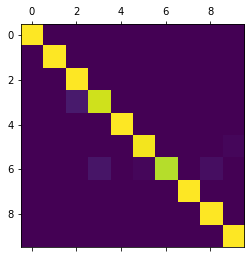

In [57]:
print('Validation confusion matrix')
print('')
print(cm_val)
plt.matshow(cm_val)
plt.show()

Test confusion matrix

[[30.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 30.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 30.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 30.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 30.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 30.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  1. 24.  0.  3.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. 30.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0. 28.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 30.]]


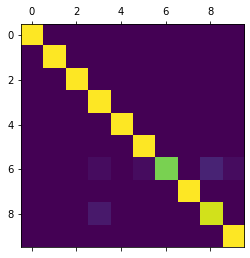

In [58]:
print('Test confusion matrix')
print('')
print(cm_test)
plt.matshow(cm_test)
plt.show()

### Βήμα 14

In [19]:
importlib.reload(lstm)

<module 'lstm' from '/root/jason/PatRec/Lab2/lstm.py'>

In [20]:
train_dataset = lstm.FrameLevelDataset(X_train, y_train)
val_dataset = lstm.FrameLevelDataset(X_dev, y_dev)
test_dataset = lstm.FrameLevelDataset(X_test, y_test)

In [21]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

In [22]:
def train_epoch(_epoch, dataloader, model, loss_function, optimizer):
    # Εnable regularization layers, such as Dropout
    model.train()
    running_loss = 0.0

    for index, batch in enumerate(dataloader, 1):
        # Get the inputs (batch)
        inputs, labels, lengths = batch

        optimizer.zero_grad()
        y_preds = model(inputs, lengths)
        loss = loss_function(y_preds, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss in a variable.
        running_loss += loss.data.item()

    return running_loss / index

In [23]:
def eval_dataset(dataloader, model, loss_function):
    model.eval()
    running_loss = 0.0

    y_pred = []  
    y = []  

    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):
            # Get the inputs (batch)
            inputs, labels, lengths = batch

            y_preds = model(inputs, lengths) 
            loss = loss_function(y_preds, labels)
            y_preds_arg = torch.argmax(y_preds, dim=1)
            y_pred.append(y_preds_arg.cpu().numpy())
            y.append(labels.cpu().numpy())
            running_loss += loss.data.item()
    return running_loss / index, (y, y_pred)

In [30]:
def train_lstm(train_data, val_data, num_layers=1, n_mfcc = 6, dropout=0, weight_decay=0, bidirectional=False):
    RNN_SIZE = 32
    OUTPUTS = 10
    EPOCHS = 50

    model = lstm.BasicLSTM(n_mfcc, RNN_SIZE, OUTPUTS, num_layers, dropout=dropout, bidirectional=bidirectional)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    total_train_loss = []
    total_val_loss = []

    for epoch in range(EPOCHS):
        # Train the model for one epoch
        train_epoch(epoch, train_data, model, loss_function, optimizer)

        train_loss, _ = eval_dataset(train_data, model, loss_function)
        val_loss, _ = eval_dataset(val_data, model, loss_function)

        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)

    return model, total_train_loss, total_val_loss

#### Basic

In [76]:
description = 'basic'
postfix = '_' + description + '.pkl'
model_str, train_loss_str, val_loss_str = 'model' + postfix, 'train_loss' + postfix, 'val_loss' + postfix
if not os.path.isfile(model_str):
    model, train_loss, val_loss = train_lstm(train_loader, val_loader)
    joblib.dump(model, model_str)
    joblib.dump(train_loss, train_loss_str)
    joblib.dump(val_loss, val_loss_str)
else: 
    model = joblib.load(model_str)
    train_loss = joblib.load(train_loss_str)
    val_loss = joblib.load(val_loss_str)

In [78]:
print('Train losses of Basic LSTM')
for x in train_loss: print(x)

Train losses of Basic LSTM
2.2865971467074226
2.2580714225769043
2.204040758750018
2.148062558735118
2.107436046880834
2.0634563950931324
2.024549936546999
1.991850246401394
1.9602742685991175
1.9302904395496143
1.901969075202942
1.8736555716570686
1.8524156423176037
1.8263681145275341
1.8032691934529472
1.7790832729900585
1.761220444651211
1.7394987344741821
1.7228301938842325
1.7002756665734684
1.685886495253619
1.6669787659364588
1.656726945849026
1.6408549371887655
1.6178113958414864
1.6046574957230513
1.5902395178289974
1.5732943801318897
1.55634343624115
1.5442560630686142
1.5198826544425066
1.5125967334298527
1.4984735881581026
1.482120857519262
1.4805212616920471
1.4556913270669825
1.4474956603611218
1.4412725743125467
1.4197436255567215
1.4109594611560596
1.3916779546176685
1.3777655889006222
1.3639122773619259
1.340801494963029
1.3177503627889298
1.3033081959275639
1.2813667023883146
1.2645825042444117
1.2340058403856613
1.2220338302500107


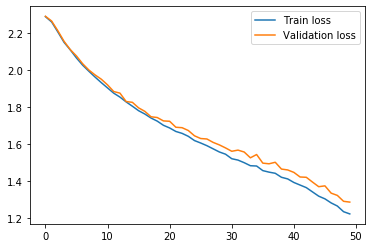

In [74]:
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [47]:
val_loss_tmp, (y, y_pred) = eval_dataset(val_loader, model, nn.CrossEntropyLoss())
print('Loss: %f' %val_loss_tmp)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 1.284427
Accuracy: 0.594444


#### Dropout - Regularisation

In [44]:
if not os.path.isfile('model_dr_reg.pkl'):
    model_dr_reg, train_loss_dr_reg, val_loss_dr_reg = train_lstm(train_loader, val_loader, num_layers=2, dropout=0.2, weight_decay=0.001)
    
    joblib.dump(model_dr_reg, 'model_dr_reg.pkl')
    joblib.dump(train_loss_dr_reg, 'train_loss_dr_reg.pkl')
    joblib.dump(val_loss_dr_reg, 'val_loss_dr_reg.pkl')
else:
    model_dr_reg = joblib.load('model_dr_reg.pkl')
    train_loss_dr_reg = joblib.load('train_loss_dr_reg.pkl')
    val_loss_dr_reg = joblib.load('val_loss_dr_reg.pkl')

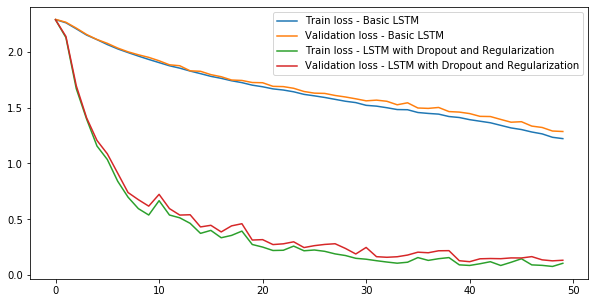

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(train_loss, label='Train loss - Basic LSTM')
ax.plot(val_loss, label='Validation loss - Basic LSTM')
ax.plot(train_loss_dr_reg, label='Train loss - LSTM with Dropout and Regularization')
ax.plot(val_loss_dr_reg, label='Validation loss - LSTM with Dropout and Regularization')
ax.legend()
plt.show()

In [49]:
val_loss_tmp, (y, y_pred) = eval_dataset(val_loader, model_dr_reg, nn.CrossEntropyLoss())
print('Loss: %f' %val_loss_tmp)
y_conc = np.concatenate(y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.145828
Accuracy: 0.957407


#### Early Stopping

In [50]:
def train_lstm_early(train_data, val_data, num_layers=1, n_mfcc = 6, dropout=0, weight_decay=0):
    RNN_SIZE = 32
    OUTPUTS = 10
    EPOCHS = 50
    EPOCHS_STOP = 10

    model = lstm.BasicLSTM(n_mfcc, RNN_SIZE, OUTPUTS, num_layers, dropout=dropout)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    total_train_loss = []
    total_val_loss = []
    epochs_no_improve = 0    
    min_val_loss = float('inf') # Initialise to infinity

    for epoch in range(EPOCHS):
        # Train the model for one epoch
        train_epoch(epoch, train_data, model, loss_function, optimizer)

        train_loss, _ = eval_dataset(train_data, model, loss_function)
        val_loss, _ = eval_dataset(val_data, model, loss_function)

        if val_loss < min_val_loss:
            # Save the model
            torch.save(model, "./model_early_stopping.pkl")
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve == EPOCHS_STOP:
            #print('Early stopping!')
            break
        
        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)

    return model, total_train_loss, total_val_loss

In [66]:
if not os.path.isfile('model_early.pkl'):
    model_early, train_loss_early, val_loss_early = train_lstm_early(train_loader, val_loader, num_layers=2, dropout=0.2, weight_decay=0.001)
    
    joblib.dump(model_early, 'model_early.pkl')
    joblib.dump(train_loss_early, 'train_loss_early.pkl')
    joblib.dump(val_loss_early, 'val_loss_early.pkl')
else:
    model_early = torch.load('model_early_stopping.pkl')
    train_loss_early = joblib.load('train_loss_early.pkl')
    val_loss_early = joblib.load('val_loss_early.pkl')

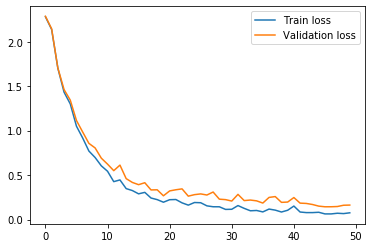

In [67]:
plt.plot(train_loss_early, label='Train loss')
plt.plot(val_loss_early, label='Validation loss')
plt.legend()
plt.show()

In [68]:
val_loss_tmp, (y, y_pred) = eval_dataset(val_loader, model_early, nn.CrossEntropyLoss())
print('Loss: %f' %val_loss_tmp)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.140998
Accuracy: 0.961111


#### Bidirectional

In [51]:
description = 'bidirectional'
postfix = '_' + description + '.pkl'
model_str, train_loss_str, val_loss_str = 'model' + postfix, 'train_loss' + postfix, 'val_loss' + postfix
if not os.path.isfile(model_str):
    model_bidirectional, train_loss_bidirectional, val_loss_bidirectional = train_lstm(train_loader, val_loader, num_layers=1, n_mfcc = 6, dropout=0, weight_decay=0, bidirectional=False)
    joblib.dump(model_bidirectional, model_str)
    joblib.dump(train_loss_bidirectional, train_loss_str)
    joblib.dump(val_loss_bidirectional, val_loss_str)
else: 
    model_bidirectional = joblib.load(model_str)
    train_loss_bidirectional = joblib.load(train_loss_str)
    val_loss_bidirectional = joblib.load(val_loss_str)

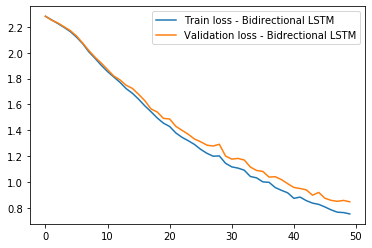

In [60]:
plt.plot(train_loss_bidirectional, label='Train loss - Bidirectional LSTM')
plt.plot(val_loss_bidirectional, label='Validation loss - Bidrectional LSTM')
plt.legend()
plt.show()

In [61]:
val_loss_tmp, (y, y_pred) = eval_dataset(val_loader, model_bidirectional, nn.CrossEntropyLoss())
print('Loss: %f' %val_loss_tmp)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.853766
Accuracy: 0.737037


#### Evaluation

In [70]:
best_model = torch.load('./model_early_stopping.pkl')
best_model.eval()

BasicLSTM(
  (lstm): LSTM(6, 32, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=32, out_features=10, bias=True)
)

In [79]:
print('Test set')
test_loss, (y_test, y_test_pred) = eval_dataset(test_loader, best_model, nn.CrossEntropyLoss())
print('Loss: %f' %test_loss)
y_test_conc = np.concatenate( y_test, axis=0 )
y_test_pred_conc = np.concatenate( y_test_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_test_conc, y_test_pred_conc))

Test set
Loss: 0.207834
Accuracy: 0.950000


Test set confusion matrix

[[28.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 27.  0.  0.  0.  1.  0.  0.  0.  2.]
 [ 0.  0. 30.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 30.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 29.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0. 29.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0. 28.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0. 29.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  3.  0. 27.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.  0. 28.]]


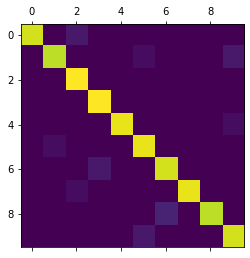

In [80]:
print('Test set confusion matrix')
print('')
best_cm = np.zeros((10, 10))
for i in range(len(y_test_conc)):
    best_cm[y_test_conc[i], y_test_pred_conc[i]] += 1

print(best_cm)

plt.matshow(best_cm)